# Lab:  Nonlinear Least-Squares for Modeling Materials

In this lab, we will explore gradient descent on nonlinear least squares.  

Suppose we wish to fit a model of the form,

     yhat ~= f(x,w)
     
where `x` is a vector of features, `w` is a vector of parameters and `f` is a nonlinear function of `w`.  Often we find the parameters `w` that minimize a squared-error cost of the form 

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This problem is known as nonlinear least-squares (NLLS).  In general, this optimization problem has no closed-form expression, and so gradient descent is widely used.  

In this lab, we will apply NLLS to the physical modeling of materials.  Specifically, we will estimate parameters in a model for the expansion of copper as a function of temperature.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets appropriate for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot `y` vs. `x`. 

236


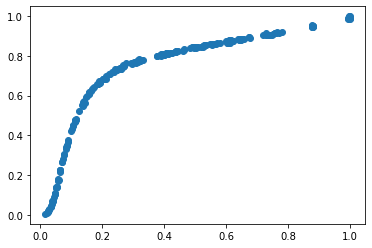

In [3]:
# TODO
# x0 = ...
# y0 = ...
# x0 = x0/np.max(x0)
# y0 = y0/np.max(y0)
# plt.plot(...)
x0=df['x0']
y0=df['y0']
x =np.array(x0/np.max(x0))
y =np.array(y0/np.max(y0))
plt.plot(x,y,'o')
print(y.shape[0])


To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

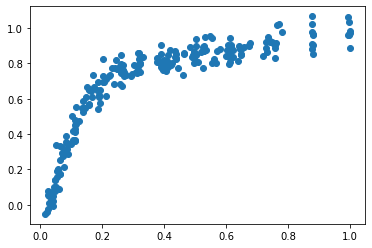

In [4]:
# TODO
# yn = y + ...
# plt.plot(...)
yn = y + np.random.normal(0,0.05,y.shape[0])
plt.plot(x,yn,'o')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts=train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]`, so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    # a = ...
    # b = ...
    a = w[0:d+1]
    b = np.append(1,w[d+1:])

    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order of a and b because np.polyval outputs
    #    a[0]*x**(d) + a[1]*x**(d-1) + ... + a[d-1]*x + a[d]
    #
    # arev = ...
    # brev = ...
    # yhat = ...
    arev = a[::-1]
    brev = b[::-1]
    m = np.polyval(arev,x)
    n = np.polyval(brev,x)
    yhat = m/n

    return yhat

When we fit with a nonlinear model, most methods only obtain convergence to a *local* minimum, which is not necessarily good.  To converge to the *global* minimum, we need a good initialization.  For a rational model, one way to get a good initialization using the following trick.  First, realize that if

    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
then, by rearranging, we get

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
Note that this latter model is not useful for *prediction* because it is predicting `y` using `y`! But it *is* useful for least-squares fitting the parameters `a` and `b` when `y` and `x` are known as training samples.  

To do this least-squares fit, we can solve for parameter vector `w = [a0,a,b]` using linear regression with the newly defined `i`th feature vector

    Z[i,:] = [ x[i], ... , x[i]**d, -y[i]*x[i], ... , -y[i]*x[i]**d ].
    
Here, `a=[a[1],...,a[d]]`, `b=[b[0],...,b[d-1]]`, and `a0` is the intercept term of the linear model.  We don't put the intercept in the `a` and `b` vectors because sklearn's `LinearRegression` method will handle it separately.

As a hint for the next block, realize that a matrix with rows `[ x[i], x[i]**2, ... , x[i]**d]` can be efficiently created using broadcasting as `xtr[:,None]**powd[None,:]`, where `powd = [1,...,d]`.  For more on broadcasting, see the demo in Unit 0, especially the "outer product" section.  

In [7]:
d = 3

# TODO.  Create the transformed feature matrix
# powd = ...
# Znum = ...  # so that Znum[i,j] = x[i]**j
# Znum = ...  # so that Zden[i,j] = -y[i]*x[i]**j
# Z = np.hstack((Znum, Zden))
powd = np.arange(1,d+1)
Znum = xtr[:,None]**powd[None,:]
Zden = -ytr[:,None]*Znum
print(powd)
Z = np.hstack((Znum, Zden))

# TODO.  Fit with parameters with linear regression
# regr = LinearRegression()
# regr.fit(...)
regr = LinearRegression()
regr.fit(Z,ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# a0 = regr.intercept_
# ab = regr.coef_
# winit = ...
a0 = regr.intercept_
ab = regr.coef_
winit = np.append(a0,ab)
print(winit)

[1 2 3]
[ -0.13936381   7.5486943  -23.98338203  17.55658722   1.90765818
 -15.52203229  13.57768574]


Now using the `predict` function and your initial parameter estimate `winit`, compute `yhat` for 1000 values of `x` uniformly spaced over the interval `[0,1]`.  Plot `yhat` versus `x`.  You should see that the prediction curve has some singularities.  On the same plot, superimpose the points `(xts,yts)`.  Use the `axis` command to focus your plot on the region near the data samples.

(-1.0, 2.0)

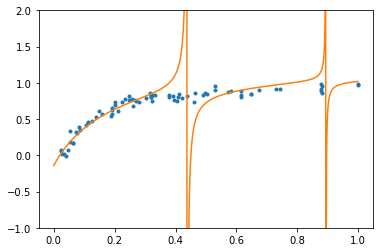

In [8]:
# TODO
# xp = ...
# yhat = ...
# plot(...)
xp = np.arange(0,1,1/1000)
yhat = predict(winit,xp)
plt.plot(xts,yts,'.')
plt.plot(xp,yhat,)
plt.ylim(-1,2)

The problem with the prediction curve is that the denominator in our polynomial model for `yhat` goes to zero at certain values of `x` in `[0,1]`.  As a result, some of the `z` features become correlated, and the least-squares fit for `winit` includes relatively large coefficient values. To alleviate this problem, we can use Ridge regression instead of least-squares, in order to keep the `winit` parameters closer to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-1`. You should see a much better (but not perfect) fit.

(-1.0, 2.0)

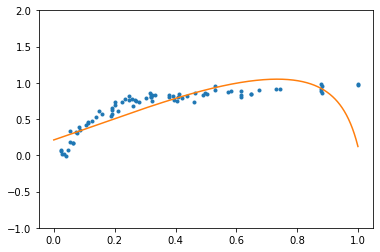

In [9]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-1)

regr = Ridge(alpha=1e-1)
regr.fit(Z,ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...
a0 = regr.intercept_
ab = regr.coef_
winit = np.append(a0,ab)
xp = np.arange(0,1,1/1000)
yhat = predict(winit,xp)
plt.plot(xts,yts,'.')
plt.plot(xp,yhat,)
plt.ylim(-1,2)
# TODO
# Plot the results as above.


## Creating a Loss Function

We can now use gradient descent to improve our initial estimate of the weights `w`.  Complete the construction of the following function, which is used to compute the RSS-like cost

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
    
    d=(len(w)-1)//2

    a = w[0:d+1]
    b = w[d+1:]


    
    # TODO.  Parse w
    # a = ...
    # b = ...

    # TODO.  
    # Znum = ... # so that Znum[i,j] = x[i]**j
    powd = np.arange(0,d+1)
    Znum = x[:,None]**powd[None,:]
    powd1 = np.arange(1,d+1)
    Zden = x[:,None]**powd1[None,:]

    # TODO.  
    # Zden = ... # so that Zden[i,j] = x[i]**(j+1)

    # TODO.  Compute yhat 
    # Compute the numerator and denominator using Znum, Zden, a, and b
    yhat=Znum.dot(a)/(1+Zden.dot(b))

    # TODO.  Compute loss
    # e = yhat-y
    # f = ...
    e = yhat-y
    f = 0.5*np.sum(e**2)

    # TODO.  Compute gradients
    # fgrad = ...
    den=e/(1+Zden.dot(b))
    dJda=den.dot(Znum)
    num=-e*yhat/(1+Zden.dot(b))
    dJdb=num.dot(Zden)
    fgrad=np.append(dJda,dJdb)
    return f, fgrad

Now, test your gradient computation:
* Set `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Make a `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
w0=winit
f0,fgrad0 = feval(w0,xtr,ytr)
step = 1e-6

w1 = w0 + step*np.random.randn(2*d+1) 

f1,fgrad1 = feval(w1,xtr,ytr)
print("f1-f0 = ",f1-f0,"\nfgrad0",fgrad0,"\nfgrad1",fgrad1,w0)

f1-f0 =  1.513649669782069e-05 
fgrad0 [-44.09537166 -45.30981694 -46.67731905 -48.03242616   0.57496766
   2.68030587   4.34746622] 
fgrad1 [-44.09484736 -45.30904321 -46.67640108 -48.03141307   0.5750299
   2.68021695   4.34727484] [ 0.21233735  1.16982042 -1.2511167  -0.12127543 -1.22426638  0.73457669
 -0.41728346]


## Implement gradient descent

We will now try to minimize the loss function using gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it` on a log-log scale.  

You should see that the training loss decreases but does not fully converge after 10000 iterations.

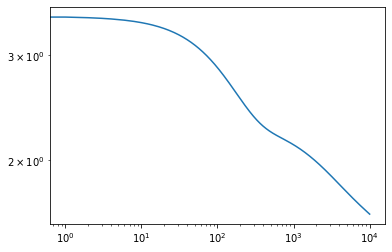

In [12]:
def grad_opt_simp(feval, winit, lr, nit):
    """
    Simple gradient descent optimization
    
    Jeval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'w':[],'f':[]}
    
    # Loop over iterations
    for it in range(nit):
    
        # Evaluate the function and gradient
        f0,fgrad0 = feval(w0,xtr,ytr)
    
        # Take a gradient step
        w0 = w0-lr*fgrad0
        
        # Save history
        hist['f'].append(f0)
        hist['w'].append(w0)
    
    # Convert to numpy arrays
    for elem in ('f','w'):
        hist[elem] = np.array(hist[elem])
        
    return w0, f0, hist
    
# Parameters
nit = 10000
step = 1e-6

# Run the gradient descent
w0, f1, hist = grad_opt_simp(feval, winit, lr=step, nit=nit)

# Plot the training loss
t = np.arange(nit)
plt.loglog(t,hist['f'])

Now try to get a faster convergence using adaptive step-size via the Armijo rule. Implement Armijo gradient descent.  Let `fadapt[it]` be the loss value that it attains on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same log-log graph.  You should see some improvement, but also some lingering problems.

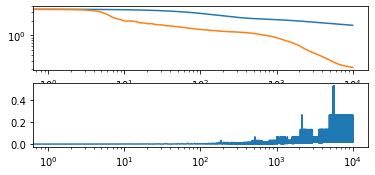

In [13]:
def grad_opt_adapt(feval, winit, lr, nit):
    w0 = winit
    f0,fgrad0 = feval(w0,xtr,ytr)
  
    hist1 = {'w':[],'f':[],'lr':[]}
    
    for it in range(nit):
        w1 = w0 - lr*fgrad0
        f1,fgrad1 = feval(w1,xtr,ytr)
        df_est = fgrad0.dot(w1-w0)
        alpha = 0.5
        if (f1-f0 < alpha*df_est) and (f1 < f0):
            lr = lr*2
            f0 = f1
            fgrad0 = fgrad1
            w0 = w1
        else:
            lr = lr/2
        hist1['f'].append(f0)
        hist1['w'].append(w0)
        hist1['lr'].append(lr)
    for elem in ('f','w','lr'):
        hist1[elem] = np.array(hist1[elem]) 
    return w0, f0, hist1
nit = 10000
step = 1e-6
w0, f1, hist1 = grad_opt_adapt(feval, winit, lr=step, nit=nit)
t = np.arange(nit)
plt.subplot(3,1,1)
plt.loglog(t,hist['f'])
plt.loglog(t,hist1['f'])
plt.subplot(3,1,2)
plt.semilogx(t,hist1['lr'])

Using the final estimate for `w` from the adaptive step-size approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot the test data, `yts` vs. `xts`.  You should see that gradient descent was able to improve the prediction model, although the initial prediction model was not too bad.

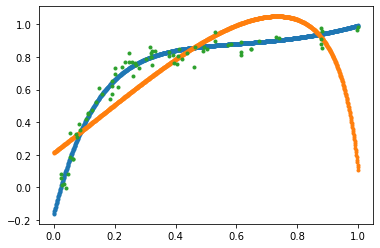

In [14]:
xp = np.linspace(0,1,num=1000)
yhat_w = predict(w0,xp)
yhat = predict(winit,xp)
plt.plot(xp,yhat_w,'.')
plt.plot(xp,yhat,'.')
plt.plot(xts,yts,'.')

## Momentum Gradient Descent

This section is optional.

One way to improve gradient descent is to use *momentum*.  With momentum, the gradient-descent update rule becomes:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that the update direction `z` is the sum of the gradient `fgrad` and the previous update direction `z`, which tends to keep the algorithm moving in the same direction (instead of randomly changing directions, as it would if `z=fgrad`).  Implement momentum gradient-descent with `beta = 0.99` and `step=1e-5`.  Compare the convergence of this approach to plain gradient descent and the adaptive stepsize version.  

In [15]:
# TODO
nit = 1000
step = 1e-5
beta = 0.99

Using the final estimate for `w` from the momentum approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the adaptive stepsize method.  Also, plot the test data, `yts` vs. `xts`.  You should see that the momentum approach gives a slightly different prediction model than the adaptive-stepsize approach.

In [16]:
# TODO
# plot yhat vs. x